In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
train_labels = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
main_path = "../input/cassava-leaf-disease-classification/train_images/"

In [7]:
train_labels.isna().sum()

image_id    0
label       0
dtype: int64

In [8]:
train_labels['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

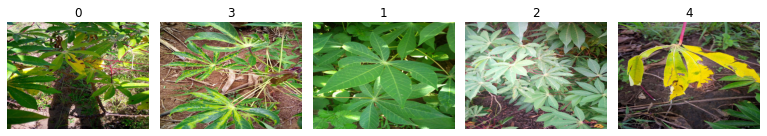

In [9]:
from PIL import Image
plt.figure(figsize=(15,12))
for id,i in enumerate(train_labels.label.unique()):
    plt.subplot(4,7,id+1)
    df = train_labels.loc[train_labels['label']==i].reset_index(drop=True)
    image_path = df.loc[0,'image_id']
    image_path = main_path + image_path
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
plt.tight_layout()
plt.show()

In [10]:
sample_path = main_path + train_labels.loc[0,'image_id']
sample_img = Image.open(sample_path)
sample_img.size

(800, 600)

In [33]:
from tensorflow.keras.applications import ResNet50
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
#Input shape
input_shape = (256, 256, 3)

cnn = Sequential()
cnn.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=5, padding ="same", input_shape=input_shape, activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))

cnn.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, padding ="same",activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))

cnn.add(tf.keras.layers.Convolution2D(filters=128, kernel_size=3, padding ="same",activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(2048, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))
cnn.add(tf.keras.layers.Dense(5, activation='softmax'))

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split=0.2,
                                  preprocessing_function = None,
                                  rescale = 1./255,
                                  rotation_range = 45,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  #fill_mode = 'Nearest',
                                  shear_range = 0.1,
                                  height_shift_range = 0.1,
                                  width_shift_range = 0.1,)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_labels,
                                                   directory = '../input/cassava-leaf-disease-classification/train_images/',
                                                   subset='training',
                                                   x_col = 'image_id',
                                                   y_col = 'label',
                                                   target_size = (256,256),
                                                   batch_size = 64,
                                                   class_mode = 'sparse',
                                                   )

validation_datagen = ImageDataGenerator(validation_split = 0.2,
                                       rescale=1./255,
                                       )

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = '../input/cassava-leaf-disease-classification/train_images/',
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (256,256),
                         batch_size = 64,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [34]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)
hist=cnn.fit_generator(train_generator,
                         steps_per_epoch = len(train_labels)*0.8 / 64,
                         epochs = 3,
                         validation_data = validation_generator,
                         validation_steps = len(train_labels)*0.2 / 64)


Epoch 1/3
268/267 [==============================] - 487s 2s/step - loss: 3.9242 - accuracy: 0.1835 - val_loss: 3.9100 - val_accuracy: 0.1161
Epoch 2/3
268/267 [==============================] - 389s 1s/step - loss: 3.8968 - accuracy: 0.1674 - val_loss: 3.9100 - val_accuracy: 0.0507
Epoch 3/3
268/267 [==============================] - 382s 1s/step - loss: 3.8968 - accuracy: 0.1705 - val_loss: 3.9100 - val_accuracy: 0.5824


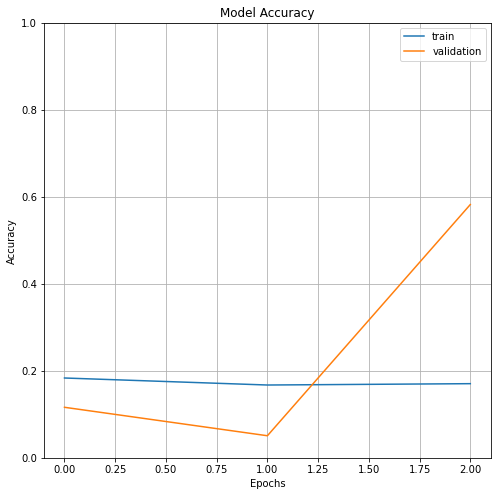

In [38]:
import matplotlib.pyplot as plotter_lib
plotter_lib.figure(figsize=(8, 8))

epochs_range= range(3)

plotter_lib.plot( epochs_range, hist.history['accuracy'], label="Training Accuracy")

plotter_lib.plot(epochs_range, hist.history['val_accuracy'], label="Validation Accuracy")

plotter_lib.axis(ymin=0,ymax=1)

plotter_lib.grid()

plotter_lib.title('Model Accuracy')

plotter_lib.ylabel('Accuracy')

plotter_lib.xlabel('Epochs')

plotter_lib.legend(['train', 'validation'])

In [39]:
plotter_lib.show()

In [42]:
ss = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
ss

,image_id,label
0,2216849948.jpg,4


In [45]:
preds = []

for image_id in ss.image_id:
    image = Image.open('../input/cassava-leaf-disease-classification/test_images/'+image_id)
    image = image.resize((256,256))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(cnn.predict(image)))

ss['label'] = preds
ss

,image_id,label
0,2216849948.jpg,4
